# Harmonization Parameters Finder

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read Data

In [10]:
def read_sensor_data(file_prefix, num_sensors=15):
    sensor_dataframes = []
    for i in range(1, num_sensors + 1):
        filename = f'harmonization_data/{file_prefix}{i:02d}.csv'
        sensor_df = pd.read_csv(filename)
        sensor_dataframes.append(sensor_df)
    return sensor_dataframes

sensor_dataframes = read_sensor_data('Indoor')

## Clean Data

In [4]:
def create_units_dict(df):
    units_dict = {}
    for column in df.columns:
        units_dict[column] = df.loc[0, column]
    return units_dict

units_dict = create_units_dict(sensor_dataframes[0])

In [137]:
def clean_sensor_dataframes(sensor_dataframes):
    numeric_columns = ['PM 1.0', 'PM 2.5', 'PM 4.0', 'PM 10',
                       'NC 0.5', 'NC 1.0', 'NC 2.5', 'NC 10',
                       'CO2', 'Barometric Pressure', 'VOC tVOC measurement',
                       'VOC Ethanol', 'Temperature', 'Relative Humidity']
    cleaned_dataframes = []
    for sensor_df in sensor_dataframes:
        # remove header
        sensor_df = sensor_df.iloc[1:]
        # Sort by 'Timestamp'
        sensor_df = sensor_df.sort_values(by=['Timestamp']).reset_index()
        # Change 'Timestamp' to date format
        sensor_df['Timestamp'] = pd.to_datetime(sensor_df['Timestamp'])
        # Filter rows based on timestamp
        sensor_df = sensor_df[sensor_df['Timestamp'] <= '2024-02-10']
        sensor_df = sensor_df.sort_values(by=['Timestamp']).reset_index()
        # Convert specified columns to numeric
        sensor_df[numeric_columns] = sensor_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
        # Append the cleaned DataFrame to the list
        cleaned_dataframes.append(sensor_df)
    return cleaned_dataframes
cleaned_sensor_dataframes = clean_sensor_dataframes(sensor_dataframes)

In [138]:
sensor_names = ['sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 
                'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10',
                'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15']

In [140]:
def aggregate_sensor_data(sensor_dataframes, column_name):
    # Extracting the specified column from each sensor dataframe
    cutoff_value = len(sensor_dataframes[3])
    selected_columns = [df[column_name] for df in sensor_dataframes]
    # Combining these columns into a new dataframe
    combined_df = pd.concat(selected_columns, axis=1)[:cutoff_value]
    combined_df.columns = [f'Sensor{i+1}' for i in range(len(sensor_dataframes))]
    return combined_df

### Plot

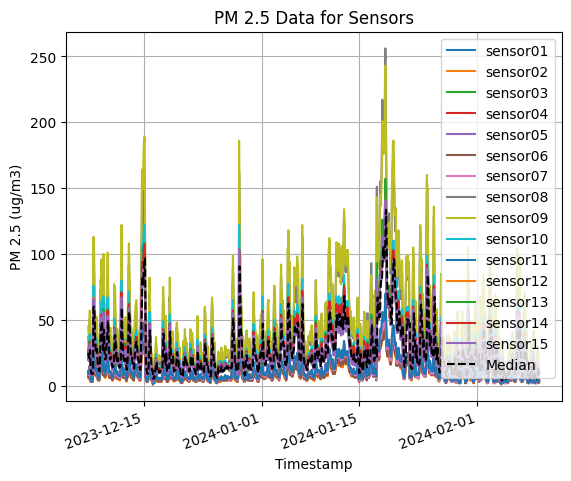

In [141]:
def plot_sensor_data(column_name, sensor_dataframes, sensor_names, units_dict, window_size=10):
    # Calculate the rolling median
    df = aggregate_sensor_data(sensor_dataframes,column_name)
    rolling_median = df.rolling(window=10, min_periods=1).median()
    for sensor_df, sensor_name in zip(sensor_dataframes, sensor_names):
        plt.plot(sensor_df['Timestamp'], sensor_df[column_name], label=sensor_name)
        
    plt.plot(sensor_dataframes[3]['Timestamp'], rolling_median.median(axis=1), color='black', linestyle='dashed', label='Median')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{column_name} ({units_dict[column_name]})')
    plt.title(f'{column_name} Data for Sensors')
    plt.legend()
    plt.xticks(rotation=20, ha='right')
    plt.grid(True)
    plt.show()

plot_sensor_data('PM 2.5', cleaned_sensor_dataframes, sensor_names, units_dict, 10)

### Harmonization Parameters

In [153]:
from sklearn.linear_model import LinearRegression

# Function to fit each sensor's data to the linear function
def fit_sensor_to_median(x, y):
    lr = LinearRegression()
    lr.fit(x, y)
    return lr.coef_[0], lr.intercept_  # Return the coefficients and intercept of the linear regression model

def fit_sensor_data(column_name, sensor_dataframes, sensor_names, units_dict, window_size=10, num_dataframes=1):
    plt.figure(figsize=(10, 6))  

    cutoff_value = len(sensor_dataframes[3])

    num_dataframes = num_dataframes
    sensor_dataframes_working = sensor_dataframes[:num_dataframes]
    sensor_names_wokring = sensor_names[:num_dataframes]

    df = aggregate_sensor_data(sensor_dataframes, column_name)
    rolling_median = df.rolling(window=window_size, min_periods=1).median()
    fitted_data_dict = {}
    coefficients_data = []

    for sensor_df, sensor_name in zip(sensor_dataframes_working, sensor_names_wokring):
        X = sensor_df[column_name].to_frame(name=column_name)[:cutoff_value]
        Y = rolling_median.median(axis=1).to_frame('median')[:cutoff_value]
        coefficients, intercept = fit_sensor_to_median(X, Y)
        fitted_data = X * coefficients + intercept
        fitted_data = fitted_data.values.flatten()
        fitted_data_dict[sensor_name] = fitted_data
        
        # Append coefficients and intercept to list
        coefficients_data.append({
            'Sensor': sensor_name,
            'Coefficient': coefficients[0],
            'Intercept': intercept[0]
        })

    # Create DataFrame from the list of coefficients and intercepts
    coefficients_df = pd.DataFrame(coefficients_data)
    return coefficients_df

In [154]:
for column_name in ['PM 2.5', 'CO2', 'Barometric Pressure', 'VOC tVOC measurement', 'Temperature', 'Relative Humidity']:
    coefficients_df = fit_sensor_data(column_name, cleaned_sensor_dataframes, sensor_names, units_dict, window_size=1, num_dataframes=15)
    filename = f"{column_name.lower().replace(' ', '_')}_coefficients_df.csv"
    coefficients_df.to_csv(filename, index=False)
    print(f"{filename} saved successfully.")

pm_2.5_coefficients_df.csv saved successfully.
co2_coefficients_df.csv saved successfully.
barometric_pressure_coefficients_df.csv saved successfully.
voc_tvoc_measurement_coefficients_df.csv saved successfully.
temperature_coefficients_df.csv saved successfully.
relative_humidity_coefficients_df.csv saved successfully.


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>